In [1]:
"""
This project was developed by Peter Chen, Rocky Duan, Pieter Abbeel for the Berkeley Deep RL Bootcamp, August 2017.
Bootcamp website with slides and lecture videos: https://sites.google.com/view/deep-rl-bootcamp/.

Code adapted from Stanford CS231N materials: http://cs231n.stanford.edu/
"""


# note to properly run this lab, you should execute all code blocks sequentially
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions

from collections import namedtuple, defaultdict, deque

import numpy as np

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

## Introduction to Chainer

Chainer can be understood as Numpy plus the ability to record the computation graph of numerical operations to enable Automatic Differentiation. (Chainer actually also offers many other things; for example, a Numpy equivalent library that runs on GPU, but we will ignore them for now)

Let's illustrate how Chainer works by a simple 1D regression task.

Suppose we have observations from the following model $y = w x + b + \epsilon$ where $\epsilon \sim \mathcal{N}(0, 0.1)$ and the task is to estimate the linear model parameters $w, b$ from data.

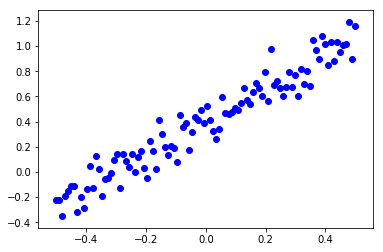

In [2]:
# first generate some observations
true_a = 1.3
true_b = 0.4
data_x = (np.arange(100) / 99.0 - .5).astype(np.float32) # Chainer assumes all the cpu computation is done in float32
data_y = (data_x * true_a + true_b + np.random.randn(*data_x.shape) * 0.1).astype(np.float32)
_ = plt.scatter(data_x, data_y, c='b')

Chainer provides an abstraction called `Link` that describe some computation and keeps track of parameters for it. For instance, a `Linear` link describes a linear map on input and keeps track of `w` and bias `b`.

In [5]:
model = L.Linear(in_size=1, out_size=1) # input is 1D data and output is also 1D data

# Chainer will randomly initialize `w` and `b` for us.
# we can take a look at their values
print("w:", model.W)
print("b:", model.b)

# model.W and model.b have type `chainer.Variable`, 
#   which is a wrapper around Numpy array
assert isinstance(model.W, chainer.Variable)

# operations that involve `chainer.Variable` will produce
#   `chainer.Variable` and this records the computation graph
var_result = model.W + 123 # some random computation
print("Operations on chainer.Variable: %s, type: %s" % (var_result, type(var_result)))

# the underlying numpy array can be accessed by `data` attribute
print("numpy arrays:", model.W.data, var_result.data)
print(data_x.shape)

w: variable W([[-0.53748727]])
b: variable b([ 0.])
Operations on chainer.Variable: variable([[ 122.46250916]]), type: <class 'chainer.variable.Variable'>
numpy arrays: [[-0.53748727]] [[ 122.46250916]]
(100,)


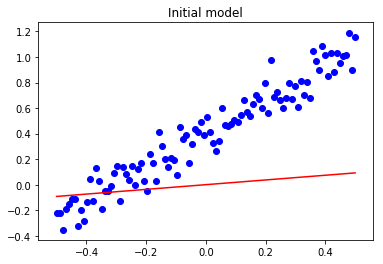

In [4]:
# A chainer link is a callable object. calling it performs the
#   forward computation. (in this case, it performs Wx + b)
model_y = model(data_x[:, None]) # chainer's link usually assumes input is [Batch Size, Input Dimension]
# `model_y` is a chainer variable so we use `.data` to access its numpy array for plotting

# we can plot the model's current fit in red. it should be terrible because we haven't trained it yet
_ = plt.plot(data_x, model_y.data[:,0], c='r')
_ = plt.scatter(data_x, data_y, c='b')
_ = plt.title("Initial model")

In [7]:
# now let's walk through how to perform forward computation
#  and use AD to get gradients

# first we clear the gradients that are stored in the model
model.cleargrads()
# as we have seen we can perform forward computation by calling the link
model_y = model(data_x[:, None])

# remember that `model_y` is a chainer variable. to operate on chainer variable
#    we will use functions from chainer.functions to operate on those objects.
loss = F.mean(F.square(model_y - data_y[:, None]))
# `loss` is a scalar chainer variable
assert isinstance(loss, chainer.Variable)
print("loss", loss)
# calculating gradients d loss /d params is as simple as
loss.backward()

# we can inspect the gradient of loss with respect to W
print("dloss/dW", model.W.grad)
print(model.W.grad)
print(model.W.data.shape)

loss variable(0.4601721167564392)
dloss/dW [[-0.31392586]]
[[-0.31392586]]
(1, 1)


Now that we know how to calculate gradients, we can code up a simple loop to perform gradient descent to train this model:

(Hint: if you run into weird problems, maybe the state has been messed up and you can try re-runing all the code blocks from the beginning)

Itr 0 loss: variable(0.18640132248401642)
Itr 10 loss: variable(0.01319817639887333)
Itr 20 loss: variable(0.01094635296612978)
Itr 30 loss: variable(0.01056546438485384)
Itr 40 loss: variable(0.01050103735178709)
Itr 50 loss: variable(0.010490138083696365)
Itr 60 loss: variable(0.01048829685896635)
Itr 70 loss: variable(0.010487985797226429)
Itr 80 loss: variable(0.010487932711839676)
Itr 90 loss: variable(0.010487924329936504)


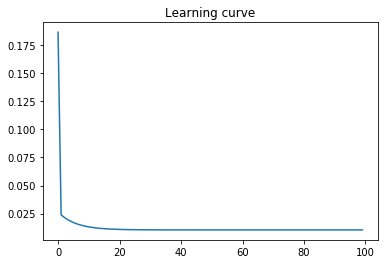

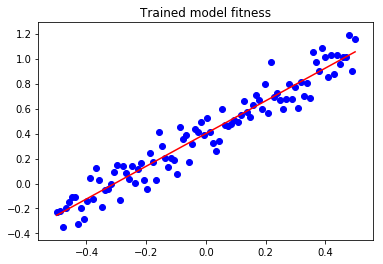

In [22]:
# now we can perform gradient descent to improve this model
model = L.Linear(in_size=1, out_size=1)
losses = []
itr = 100

for i in range(itr):
    model.cleargrads()
    loss = F.mean(F.square(model(data_x[:, None]) - data_y[:, None]))
    losses.append(float(loss.data))
    ## *** YOUR CODE HERE TO PERFORM GRADIENT DESCENT ***
    ## Hint: you could access gradients with model.W.grad, model.b.grad
    ## Hint2: you could write data into a parameter with model.W.data[:] = some_numpy_array
    ## Hint3: if your model doesn't learn, remember to try different learning rates
    loss.backward()
    
    lr = 0.5 # learning rate for gradient descent
    
    model.W.data[:] -= lr * model.W.grad
    model.b.data[:] -= lr * model.b.grad
    
    if i % (itr / 10) == 0:
        print("Itr", i, "loss:", loss)
plt.plot(np.array(losses))
plt.title("Learning curve")
plt.figure()
plt.plot(data_x, model(data_x[:, None])[:,0].data, c='r')
plt.scatter(data_x, data_y, c='b')
_ = plt.title("Trained model fitness")


## Train your first deep model

Now we have learned the basics of Chainer. We can use it to train a deep model to classify MNIST digits. We will train a model on the MNIST dataset because the dataset is small.

First we load the data and see what the images look like:

train[i][0] is the ith image that's flattened, and has shape: (784,)
train[i][1] is the ith image's label, such as: 3


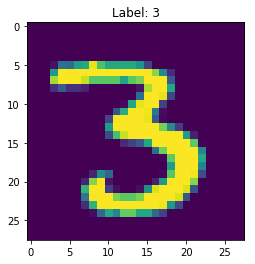

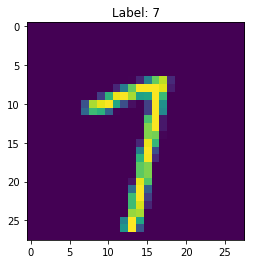

In [23]:
train, test = chainer.datasets.get_mnist()
# use train[data_point_index] to access data
print("train[i][0] is the ith image that's flattened, and has shape:", train[12][0].shape)
print("train[i][1] is the ith image's label, such as:", train[12][1])
# here we visualize two of them
plt.imshow(train[12][0].reshape([28, 28,]))
plt.title("Label: %s" % train[12][1])
plt.figure()
plt.imshow(train[42][0].reshape([28, 28,]))
_ = plt.title("Label: %s" % train[42][1])

Next we will provide some boilerplate code and train a linear classifier as an example:

In [24]:
def run(model, batchsize=16, num_epochs=2):
    
    optimizer = chainer.optimizers.Adam() # we will use chainer's Adam implementation instead of writing our own gradient based optimization
    optimizer.setup(model)
    
    stats = defaultdict(lambda: deque(maxlen=25))
    for epoch in range(num_epochs):
        train_iter = chainer.iterators.SerialIterator(train, batchsize, repeat=False, shuffle=True)
        test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)
        
        for itr, batch in enumerate(train_iter):
            xs = np.concatenate([datum[0][None, :] for datum in batch])
            ys = np.array([datum[1] for datum in batch])

            logits = model(xs)

            loss = F.softmax_cross_entropy(logits, ys)
            model.cleargrads()
            loss.backward()
            optimizer.update()
            
            # calculate stats
            stats["loss"].append(float(loss.data))
            stats["accuracy"].append(float((logits.data.argmax(1) == ys).sum() / batchsize))
            if itr % 300 == 0:
                print("; ".join("%s: %s" % (k, np.mean(vs)) for k, vs in stats.items()))

# try a simple linear model
run(L.Linear(None, 10))

accuracy: 0.0625; loss: 2.34032988548
accuracy: 0.8525; loss: 0.598630113602
accuracy: 0.875; loss: 0.471965401769
accuracy: 0.855; loss: 0.486075101495
accuracy: 0.91; loss: 0.377774413824
accuracy: 0.8625; loss: 0.437305779755
accuracy: 0.9075; loss: 0.322643093467
accuracy: 0.9125; loss: 0.319489635825
accuracy: 0.905; loss: 0.318381639421
accuracy: 0.9025; loss: 0.291053823233
accuracy: 0.8825; loss: 0.350318266451
accuracy: 0.9075; loss: 0.326097099781
accuracy: 0.91; loss: 0.30339533776
accuracy: 0.91; loss: 0.354103405774
accuracy: 0.91; loss: 0.305984061211
accuracy: 0.9125; loss: 0.305028057992
accuracy: 0.9275; loss: 0.294065425098
accuracy: 0.9025; loss: 0.331497419477
accuracy: 0.905; loss: 0.315456804633
accuracy: 0.91; loss: 0.294870039225
accuracy: 0.9075; loss: 0.32129611522
accuracy: 0.905; loss: 0.34845443964
accuracy: 0.9475; loss: 0.233094307482
accuracy: 0.9375; loss: 0.238038635552
accuracy: 0.94; loss: 0.236493348628
accuracy: 0.9175; loss: 0.323040632606


Next we will try to improve performance by training an MLP instead. A partial implementation is provided for you to fill in:

In [26]:
class MLP(chainer.Chain):

    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            # the size of the inputs to each layer will be inferred
            self.l1 = L.Linear(None, n_units)  # n_in -> n_units
            self.l2 = L.Linear(None, n_units)  # n_units -> n_units
            self.l3 = L.Linear(None, n_out)  # n_units -> n_out

    def __call__(self, x):
        # *** YOUR CODE HERE TO BUILD AN MLP W/ self.l1, self.l2, self.l3 ***
        # 
        # Hint: you should make use of non-linearities / activation functions
        #     https://docs.chainer.org/en/stable/reference/functions.html#activation-functions
        # raise NotImplementedError()
        out_l1 = F.sigmoid(self.l1(x))
        out_l2 = F.sigmoid(self.l2(out_l1))
        out = self.l3(out_l2)
        return out
run(MLP(200, 10))

accuracy: 0.125; loss: 2.42957687378
accuracy: 0.875; loss: 0.541431388855
accuracy: 0.9125; loss: 0.357215012908
accuracy: 0.915; loss: 0.284769186974
accuracy: 0.905; loss: 0.322890809178
accuracy: 0.935; loss: 0.222510794401
accuracy: 0.91; loss: 0.242181221843
accuracy: 0.925; loss: 0.242365814447
accuracy: 0.92; loss: 0.251047032475
accuracy: 0.95; loss: 0.184854063988
accuracy: 0.9375; loss: 0.204441981912
accuracy: 0.9625; loss: 0.210484271049
accuracy: 0.93; loss: 0.212358283997
accuracy: 0.93; loss: 0.235243062377
accuracy: 0.9425; loss: 0.186458755732
accuracy: 0.9725; loss: 0.105167805552
accuracy: 0.9575; loss: 0.127607072592
accuracy: 0.95; loss: 0.157956313789
accuracy: 0.9575; loss: 0.179014304578
accuracy: 0.96; loss: 0.124222531021
accuracy: 0.945; loss: 0.176123780012
accuracy: 0.9625; loss: 0.145336849689
accuracy: 0.9575; loss: 0.126925991774
accuracy: 0.9775; loss: 0.0807005056739
accuracy: 0.9925; loss: 0.0428945034742
accuracy: 0.9675; loss: 0.0944655385613


Next you should try to implement logging test loss and see if the model is overfitting.

In [28]:
def better_run(model, batchsize=16, num_epochs=2):

    optimizer = chainer.optimizers.Adam() # we will use chainer's Adam implementation instead of writing our own gradient based optimization
    optimizer.setup(model)
    
    stats = defaultdict(lambda: deque(maxlen=25))
    for epoch in range(num_epochs):
        train_iter = chainer.iterators.SerialIterator(train, batchsize, repeat=False, shuffle=True)
        for itr, batch in enumerate(train_iter):
            xs = np.concatenate([datum[0][None, :] for datum in batch])
            ys = np.array([datum[1] for datum in batch])

            logits = model(xs)

            loss = F.softmax_cross_entropy(logits, ys)
            model.cleargrads()
            loss.backward()
            optimizer.update()
            
            # calculate stats
            stats["loss"].append(float(loss.data))
            stats["accuracy"].append(float((logits.data.argmax(1) == ys).sum() / batchsize))
            if itr % 300 == 0:
                test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)
                # *** YOUR CODE implement logging of stats on test set ***
                for itr_test, batch_test in enumerate(test_iter):
                    xs_test = np.concatenate([d[0][None, :] for d in batch])
                    ys_test = np.array([d[1] for d in batch])
                    
                    logits_test = model(xs_test)
                    
                    loss_test = F.softmax_cross_entropy(logits_test, ys)
                    
                    stats["test loss"].append(float(loss_test.data))
                    
                print("; ".join("%s: %s" % (k, np.mean(vs)) for k, vs in stats.items()))

better_run(MLP(200, 10))

test loss: 2.31871533394; accuracy: 0.0; loss: 2.45276689529
test loss: 0.56797772646; accuracy: 0.86; loss: 0.581387865543
test loss: 0.106827184558; accuracy: 0.9; loss: 0.358865501285
test loss: 0.253973275423; accuracy: 0.9025; loss: 0.294294090271
test loss: 0.245372533798; accuracy: 0.9025; loss: 0.299860730171
test loss: 0.052557259798; accuracy: 0.93; loss: 0.22606243372
test loss: 0.294285058975; accuracy: 0.9375; loss: 0.218195562363
test loss: 0.538437902927; accuracy: 0.93; loss: 0.199089818001
test loss: 0.23218691349; accuracy: 0.91; loss: 0.260336458683
test loss: 0.19368262589; accuracy: 0.9325; loss: 0.2425933218
test loss: 0.065010279417; accuracy: 0.9375; loss: 0.205106070042
test loss: 0.354967653751; accuracy: 0.925; loss: 0.236370804906
test loss: 0.17680093646; accuracy: 0.945; loss: 0.157186422944
test loss: 0.0908408761024; accuracy: 0.955; loss: 0.163503357768
test loss: 0.0298972725868; accuracy: 0.9525; loss: 0.155067546368
test loss: 0.0638807266951; accura

Try different variants!

- Does using a ConvNet improve performance (reduce overfitting?)
- Try changing the learning rate and observe the effect
- Does the model train if you give it correlated gradients? (consecutively sample many batches of "1", then many batches of "2", ... etc